## CNN Engineering from Scratch | Chihuaha or Muffin?

<p style='text-align: justify;'> It has been a while since the meme titled 'How to Confuse Machine Learning' has been revolving around the internet. The meme humorously showcases a set of images with Chihuahuas and blueberry muffins that look so similar that even a human might get confused in identifying which is which. Despite the difficulty, I wondered if it is actually confusing for an ML model to detect the difference. </p>
    
<p style='text-align: justify;'> During my deep learning studies, I was fascinated by the architecture, mathematics, and the working of neural networks. I decided to work on building a Convolutional Neural Network from scratch, without relying on any modern deep learning frameworks such as PyTorch or TensorFlow. My goal is to create a model that can accurately distinguish between Chihuahuas and muffins, ultimately aiming to debunk this meme. </p>

_____________

_Import Libraries_

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import os
from os import listdir
import PIL
from PIL import Image as im

-------------------------------------

### 1 - DATA SETUP

There are 640 Chihuahua images and 544 Muffin images that are clustered and unlabeled:

1. Import these images and convert them into pixel values (x) (numeric data).
2. Label these images (y) with its true labels. This can be 0 for Chihuahua and 1 for Muffin.
3. Create variables for the image pixels and its corresponding labels.
4. Create Train, Validation and Test sets.

_Import the images and convert them into pixel values (x) (numeric data)_

In [2]:
chihuahua_dir = r"C:/Users/asifs/OneDrive/Desktop/Chihuahua X Muffin/dataset/chihuahua"
chimgs = []
for image_ in os.listdir(chihuahua_dir):
    image_path = os.path.join(chihuahua_dir, image_)
    chim = im.open(image_path, 'r')
    small = chim.resize((32, 32))
    chimgs.append(small)

In [3]:
chihuahua_data = np.array(chimgs)

In [4]:
chihuahua_data.shape

(639, 32, 32, 3)

In [5]:
muffin_dir = r"C:/Users/asifs/OneDrive/Desktop/Chihuahua X Muffin/dataset/muffin"
mufimgs = []
for image_ in os.listdir(muffin_dir):
    image_path = os.path.join(muffin_dir, image_)
    mufim = im.open(image_path, 'r')
    small = mufim.resize((32, 32))
    mufimgs.append(small)

In [6]:
muffin_data = np.array(mufimgs)

In [7]:
muffin_data.shape

(543, 32, 32, 3)

_Label these images (y) with its true labels. This can be 0 for Chihuahua and 1 for Muffin_

In [8]:
c_labels = np.zeros(chihuahua_data.shape[0])
m_labels = np.ones(muffin_data.shape[0])

_Create variables for the image pixels and its corresponding labels_

In [9]:
image_pixels = np.concat((chihuahua_data, muffin_data), axis = 0)
labels = np.concat((c_labels, m_labels), axis = 0)

_Create Train, Validation and Test sets_

In [10]:
# currently the first 639 imgaes are of chihuahuas and the remianing are of muffins.
# this will affect the train-val-test split. so we shuffle.

indices = np.arange(image_pixels.shape[0])
np.random.shuffle(indices)

shuffled_image_pixels = image_pixels[indices]
shuffled_labels = labels[indices]

X_train = shuffled_image_pixels[:1000]
X_val = shuffled_image_pixels[1000:1091]
X_test = shuffled_image_pixels[1091:]

y_train = shuffled_labels[:1000]
y_val = shuffled_labels[1000:1091]
y_test = shuffled_labels[1091:]

print('X_train\t', X_train.shape)
print('y_train\t', y_train.shape)
print('X_val\t', X_val.shape)
print('y_val\t', y_val.shape)
print('X_test\t', X_test.shape)
print('y_test\t', y_test.shape)

X_train	 (1000, 32, 32, 3)
y_train	 (1000,)
X_val	 (91, 32, 32, 3)
y_val	 (91,)
X_test	 (91, 32, 32, 3)
y_test	 (91,)


------------------------------------

### 2 - MODEL ARCHITECTURE

<p style='text-align: justify;'> My initial plan for the model architecture follows the figure below; the input will be passed through the convolution layer, followed by max pooling and ReLU activation. This will be flattened and passed into the fully connected section. It should be noted that there are only one convolutinal layer and one hidden layer. Also, the outputs are normaized between the ranges of -1 and +1 at two locations; right after flattening and right after the affine layer. Sigmoid activation is applied and binary cross entropy loss is used for calculating the loss. </p>

> _<p style='text-align: justify;'> This is just an initial prototype of the model. Changes will be made accordingly in order to improve the performance. These might inlcude adding more colovoutinal layers, adding more hidden layers, applying droupout, applying residual networks, batch normalization, etc. </p>_

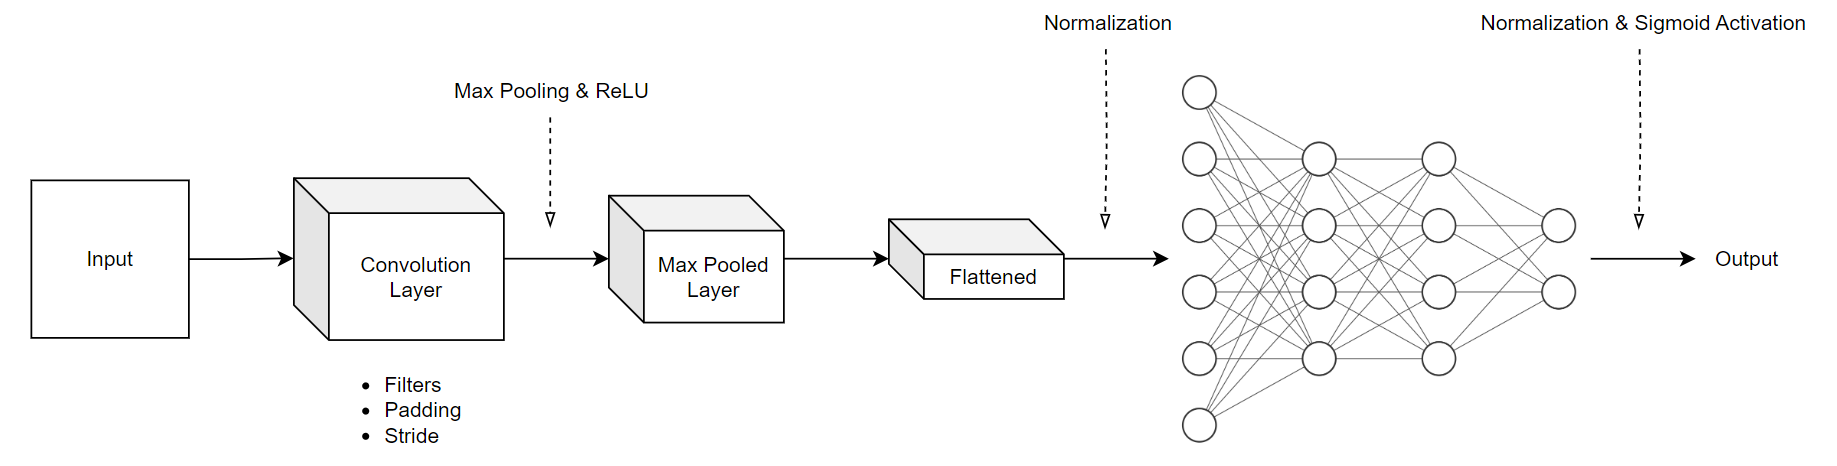

_____________________

### 3a - MODEL TRAINING | Forward Pass

#### Convolution

In [11]:
# so we have X_train, which will be our image matrix of shape (1000, 32, 32, 3).
# the filter_weights matrix will pass through the image with a specific stride. 
# a padding must be set to preserve the dimentions.
# 1 conv layer will have 36 filters of size 10 x 10 each.

filter_weights = np.random.randn(36, 7, 7, 3)
filter_biases = np.random.randn(36,)

stride = 1
pad = 3
image_h, image_w = X_train.shape[1], X_train.shape[2]
filter_h, filter_w = filter_weights.shape[1], filter_weights.shape[2]
num_images = X_train.shape[0]

X_train_padded = np.pad(X_train, ((0, 0), (pad, pad), (pad, pad), (0, 0)), mode = 'constant') # input matrix

image_h_out = 1 + (image_h + 2 * pad - filter_h) // stride # formula for calculating height of output 
image_w_out = 1 + (image_w + 2 * pad - filter_w) // stride # formula for calculating width of output
channel_out = filter_weights.shape[0] # output channels

out = np.zeros((num_images, image_h_out, image_w_out, channel_out))

counter = 0

for i in range(num_images):
    for j in range(image_h_out):
        for k in range(image_w_out):
            for l in range(channel_out):
                h_start = j * stride # height starting point for filter traversal
                h_end = h_start + filter_h # height ending point for filter traversal
                w_start = k * stride # width starting point for filter traversal
                w_end = w_start + filter_w # width ending point for filter traversal

                out[i, j, k, l] = np.sum(X_train_padded[i, h_start:h_end, w_start:w_end, :] * filter_weights[l, :, :, :] * filter_biases[l]) 

                counter += 1

    if (i + 1) % 200 == 0:
        print('Images Processed:', i + 1)

Images Processed: 200
Images Processed: 400
Images Processed: 600
Images Processed: 800
Images Processed: 1000


#### Max Pooling

In [12]:
pool_h, pool_w = 2, 2 # height and width of pool region
stride = 2

num_images = out.shape[0] # 1000
image_h = out.shape[1] # 32
image_w = out.shape[2] # 32
num_channels = out.shape[3] # 36

pool_h_out = 1 + (image_h - pool_h) // stride # formula for calculating height of pooled output
pool_w_out = 1 + (image_w - pool_w) // stride # formula for calculating width of pooled output

pooled_out = np.zeros((num_images, pool_h_out, pool_w_out, num_channels))

for i in range(num_images):
    for j in range(pool_h_out):
        for k in range(pool_w_out):
            for l in range(num_channels):
                pool_h_start = j * stride
                pool_h_end = pool_h_start + pool_h
                pool_w_start = k * stride
                pool_w_end = pool_w_start + pool_w

                pool_region = out[i, pool_h_start:pool_h_end, pool_w_start:pool_w_end, l] 
                pooled_out[i, j, k, l] = np.max(pool_region)

print('Max Pooled Output Shape\t', pooled_out.shape[1:])

Max Pooled Output Shape	 (16, 16, 36)


#### Flatten

In [13]:
flat = pooled_out.reshape(1000, -1)
print(flat)

[[  968.57638837   -15.23391558   749.66850789 ...  1803.2994653
   2565.96920931  -823.24262218]
 [ 1408.31545047    15.65185874   445.77765994 ...  2236.80472968
   3419.0649862  -1231.14686035]
 [ 1080.65914736   -13.06159656  1776.22407414 ...  1125.4129596
   1927.809397    -781.77888542]
 ...
 [ 1267.71497589    11.81214787   584.74150014 ...  2876.28704679
   3399.30607709 -1415.78333147]
 [  568.43806262    -7.95244701   546.70500849 ...   676.84970302
    571.01911833  -319.05480939]
 [  732.74970208    -5.62626995   375.82824739 ...  1312.87504894
   2998.91650907  -894.57825852]]


#### Normalization

In [14]:
flat_norm = 2 * ((flat - flat.min()) / (flat.max() - flat.min())) - 1
print(flat_norm)

[[-0.06412872 -0.1854521  -0.09112441 ...  0.03880925  0.1328616
  -0.28509565]
 [-0.00990014 -0.18164327 -0.1286002  ...  0.09226907  0.23806528
  -0.33539835]
 [-0.05030668 -0.18518421  0.03547031 ... -0.04478765  0.0541638
  -0.27998234]
 ...
 [-0.02723898 -0.18211678 -0.11146319 ...  0.17112996  0.23562861
  -0.3581677 ]
 [-0.11347373 -0.18455415 -0.11615385 ... -0.10010442 -0.11315544
  -0.22291926]
 [-0.09321084 -0.18426728 -0.13722635 ... -0.02166984  0.18625261
  -0.29389275]]


#### ReLU Activation

In [15]:
relu_out = np.maximum(0, flat_norm)
print(relu_out)

[[0.         0.         0.         ... 0.03880925 0.1328616  0.        ]
 [0.         0.         0.         ... 0.09226907 0.23806528 0.        ]
 [0.         0.         0.03547031 ... 0.         0.0541638  0.        ]
 ...
 [0.         0.         0.         ... 0.17112996 0.23562861 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.18625261 0.        ]]


#### Affine Layer

In [16]:
# the fully connected section has 1 hidden layer with 50 neurons

input_features = relu_out.shape[1] # 9216
neurons_layer1 = 50
neurons_layer2 = 1

w1 = np.random.randn(input_features, neurons_layer1)
w2 = np.random.randn(neurons_layer1, neurons_layer2)
b1 = np.random.randn(neurons_layer1)
b2 = np.random.randn(neurons_layer2)

hidden_out = np.dot(relu_out, w1) + b1 # (1000, 9216) -dot- (9216, 50) = (1000, 50)
affine_out = np.dot(hidden_out, w2) + b2 # (1000, 50) -dot- (50, 1) = (1000, 1)

#### Normalization 

In [17]:
norm_out = 2 * ((affine_out - affine_out.min()) / (affine_out.max() - affine_out.min())) - 1

#### Sigmoid Activation

In [18]:
y_pred = 1.0 / (1.0 + np.exp(-norm_out))

#### Binary Cross-Entropy Loss

In [19]:
epsilon = 1e-15
y_true = y_train.reshape(1000, 1)
y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
loss = - np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)) / y_true.shape[0]     
print('Loss:', loss)

Loss: 0.7047923749113689


### 3b - MODEL TRAINING | Backpropagation

<p style='text-align:justify'> The goal here is to calculate the gradient of the loss with respect to the input variables. This includes the inputs to the affine layer (weights and biases) and the inputs to the convolutional layer (filter weights and filter biases). To achieve this, intermediate gradients must be calculated. Finally, by applying the chain rule, we can obtain the gradients of the loss with respect to the respective inputs. </p>

#### Gradient of Loss w.r.t Activated Output

In [20]:
grad_loss_wrt_aco = - (y_true / y_pred) + ((1 - y_true) / (1 - y_pred))

#### Gradient of Activated Output w.r.t Normalized Output

In [21]:
grad_aco_wrt_no = np.exp(-norm_out) / (1 + np.exp(-norm_out)) ** 2

#### Gradient of Normalized Output w.r.t Affine Output

In [22]:
grad_no_wrt_afo_scalar = 2 / (affine_out.max() - affine_out.min())
grad_no_wrt_afo = np.full_like(affine_out, grad_no_wrt_afo_scalar)

> <p style='text-align:justify'> Now we need to calculate the gradient of The Affine Output w.r.t the Hidden Output, W2, and b2. But before calculating these gradients, we need to calculate the gradient of the Loss w.r.t the Affine Output as this will give the information on how the affine output affects the loss, which is used to update the weights and biases during training, specifically in this case, W2 and b2. </p>

#### Gradient of Loss w.r.t Affine Output

In [23]:
grad_loss_wrt_afo = grad_loss_wrt_aco * grad_aco_wrt_no * grad_no_wrt_afo

#### Gradient of Affine Output w.r.t:
1. Hidden Output
2. W2
3. B2

In [24]:
# gradient of affine output w.r.t hidden output
grad_afo_wrt_ho = np.dot(grad_loss_wrt_afo, w2.T)

# gradient of affine output w.r.t w2
grad_afo_wrt_w2 = np.dot(hidden_out.T, grad_loss_wrt_afo)

# gradient of affine output w.r.t b2
grad_afo_wrt_b2 = np.sum(grad_loss_wrt_afo, axis = 0)

> <p style='text-align:justify'> Now we need to calculate the gradient of The Hidden Output w.r.t the Normalized Flattened Output, W1, and b1. But before calculating these gradients, we need to calculate the gradient of the Loss w.r.t the Hidden Output as this will give the information on how the hidden layer affects the loss, which is used to update the weights and biases during training, specifically in this case, W1 and b1. Since we have calculated the gradient of the Loss w.r.t the Affine Output earlier, we just need to multiply that with the Gradient of the Affine Output w.r.t the Hidden Output to get the gradient of the Hidden Output w.r.t the Loss. </p>

#### Gradient of Loss w.r.t Hidden Output

In [25]:
grad_loss_wrt_ho = grad_loss_wrt_afo * grad_afo_wrt_ho

#### Gradient of Hidden Output w.r.t:
1. Activated Flattened Output
2. W1
3. B1

In [26]:
# gradient of hidden output w.r.t activated flattened output
grad_ho_wrt_afo = np.dot(grad_loss_wrt_ho, w1.T)

# gradient of hidden output w.r.t w1
grad_ho_wrt_w1 = np.dot(flat_norm.T, grad_loss_wrt_ho)

# gradient of hidden output w.r.t b1
grad_ho_wrt_b1 = np.sum(grad_loss_wrt_ho, axis = 0)

#### Gradient of Activated Flattened Output w.r.t Normalized Flattened Output

In [27]:
grad_afo_wrt_nfo = np.where(flat_norm > 0, 1, 0)

#### Gradient of Normalized Flattened Output w.r.t Flattened Output

In [28]:
grad_nfo_wrt_fo_scalar = 2 / (flat.max() - flat.min())
grad_nfo_wrt_fo = np.full_like(flat, grad_nfo_wrt_fo_scalar)

#### Gradient of Flattened Output w.r.t. Max-Pool Output

Here, there isn't any computation, we simply reshape the gradient back to the shape of the max-pool output.

In [29]:
grad_fo_wrt_mpo = grad_nfo_wrt_fo.reshape(1000, 16, 16, 36)

#### Gradient of Max-Pooled Output w.r.t Convolution Out

In [30]:
pool_h, pool_w = 2, 2 # height and width of pool region
stride = 2

num_images = pooled_out.shape[0]
image_h = pooled_out.shape[1]
image_w = pooled_out.shape[2]
num_channels = pooled_out.shape[3]

pool_h_out = 1 + (image_h - pool_h) // stride # formula for calculating height of pooled output
pool_w_out = 1 + (image_w - pool_w) // stride # formula for calculating width of pooled output

grad_mpo_wrt_co = np.zeros((num_images, image_h, image_w, num_channels))

for i in range(num_images):
    for j in range(pool_h_out):
        for k in range(pool_w_out):
            for l in range(num_channels):
                pool_h_start = j * stride
                pool_h_end = pool_h_start + pool_h
                pool_w_start = k * stride
                pool_w_end = pool_w_start + pool_w
    
                pool_region = pooled_out[i, pool_h_start:pool_h_end, pool_w_start:pool_w_end, l]
                max_window = np.max(pool_region)
                mask = (pool_region == max_window)
    
                grad_mpo_wrt_co[i, pool_h_start:pool_h_end, pool_w_start:pool_w_end, l] += mask * grad_fo_wrt_mpo[i, j, k, l]

#### Gradient of Convolution Output w.r.t Filter Weights & Biases

In [31]:
X_train = X_train.astype(np.float64)
filter_weights = filter_weights.astype(np.float64)

stride = 1
pad = 3

image_h_out = grad_mpo_wrt_co.shape[1]
image_w_out = grad_mpo_wrt_co.shape[2]

num_images = X_train.shape[0]
filter_h = filter_weights.shape[1]
filter_w = filter_weights.shape[2]
num_filters = filter_weights.shape[0]

grad_co_wrt_input = np.zeros_like(X_train)
grad_co_wrt_fw = np.zeros_like(filter_weights)
grad_co_wrt_fb = np.zeros_like(filter_biases)

input_padded = np.pad(X_train, ((0, 0), (pad, pad), (pad, pad), (0, 0)), mode = 'constant')
grad_co_wrt_input_padded = np.pad(grad_co_wrt_input, ((0, 0), (pad, pad), (pad, pad), (0, 0)), mode = 'constant')

grad_co_wrt_fb = np.sum(grad_mpo_wrt_co, axis = (0, 1, 2))

for i in range(num_images):
  for j in range(image_h_out):
    for k in range(image_w_out):
      for l in range(num_filters):
        h_start = j * stride
        h_end = h_start + filter_h
        w_start = k * stride
        w_end = w_start + filter_w

        grad_co_wrt_fw[j] += input_padded[i, h_start:h_end, w_start:w_end, :] * grad_mpo_wrt_co[i, j, k, l]
        grad_co_wrt_input_padded[i, h_start:h_end, w_start:w_end, :] += filter_weights[j] * grad_mpo_wrt_co[i, j, k, l]

# to remove padding, if applied
if pad != 0:
  grad_co_wrt_input = grad_co_wrt_input_padded[:, pad:-pad, pad:-pad, :]
else:
  grad_co_wrt_input = grad_co_wrt_input_padded

<p style='text-align:justify'> Now we need to calculate the gradients of the Loss with respect to all the different parameters. These are the filter weights and filter biases applied over the convolutional layer and the weights and bises applied over the affine layer; w1, b1, w2 and b2. For this, we need ot muliply all the respective intermediate gradients for each of those parametrs to get th final gradient based on the concept of chain rule. </p>

### 3c- MODEL TRAINING | Updating Parameters

<p style='text-align:justify'> Now that we have completed exactly one iteration, we have to repeat this, but by adjusting the weigths and biases based on a learning rate. This is done by subtracting the originally initialized parameter, with the learning rate multiplyed by the gradient of that parameter. </p>

$$
\text{parameter} = \text{parameter} - \text{learning rate} \times \text{gradient of parameter}
$$

<p style='text-align:justify'> The weights and biases include fw & fb, which are the parameters involved in the convolutional layer, followed by w1, b1, w2 & b2, which are the parameters involved in the affine layer. </p>